In [35]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = '/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting'

In [36]:
data = {
    'tra':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip'),
    'as':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip'),
    'hs':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip'),
    'ar':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip'),
    'hr':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip'),
    'id':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip'),
    'tes':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip'),
    'hol':
    pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recruit-restaurant-visitor-forecasting/date_info.csv.zip').rename(columns={
        'calendar_date': 'visit_date'
    })
}
display(data['hr'].head())
display(data['id'].head())
display(data['ar'].head())

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [37]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    display(data[df].head())

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4


,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5


In [13]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [14]:
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


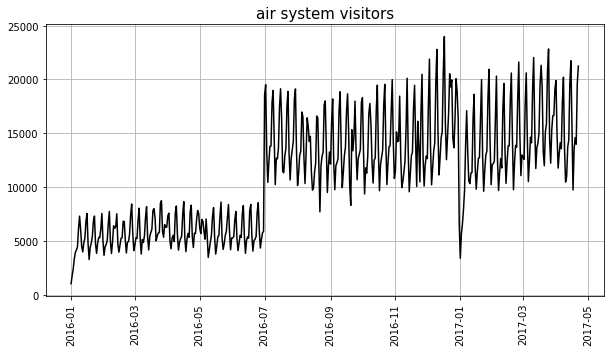

In [14]:
copy_tra = data["tra"]

copy_tra = copy_tra.groupby(
        ['visit_date'], as_index=False)[[
            'visitors'
        ]].sum()

plt.figure(figsize=(10,5))
plt.title("air system visitors", fontsize=15)
plt.plot(copy_tra["visit_date"].dt.date, copy_tra["visitors"], color='black')
plt.grid()
plt.xticks(rotation=90)
plt.show()

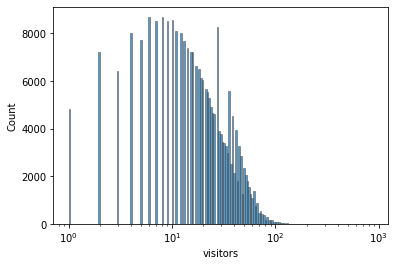

In [18]:
sns.histplot(
    data['tra'],
    x="visitors",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

In [5]:
data['hr']

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5
...,...,...,...,...
18615,air_fea5dc9594450608,2017-04-21,2,2
18616,air_fea5dc9594450608,2017-04-22,0,2
18617,air_fea5dc9594450608,2017-04-25,9,2
18618,air_fea5dc9594450608,2017-04-28,29,3


In [38]:
data["ar"]["visit_date"]=pd.to_datetime(data["ar"]["visit_date"])

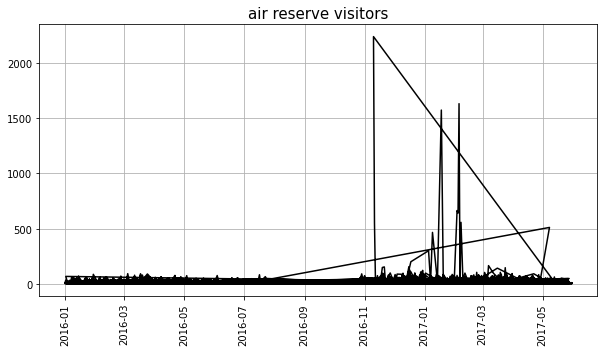

In [39]:
copy_ar = data["ar"]
copy_ar_1 = copy_ar.groupby(
        ['visit_date'], as_index=False)[[
            'reserve_visitors'
        ]].sum()

plt.figure(figsize=(10,5))
plt.title("air reserve visitors", fontsize=15)
plt.plot(copy_ar["visit_date"].dt.date, copy_ar["reserve_visitors"], color='black')
plt.grid()
plt.xticks(rotation=90)
plt.show()

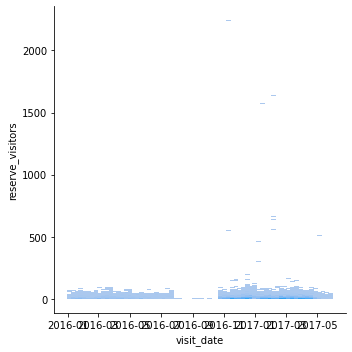

In [40]:
sns.displot(data["ar"], x = data["ar"]["visit_date"], y = data["ar"]["reserve_visitors"], kind="hist")

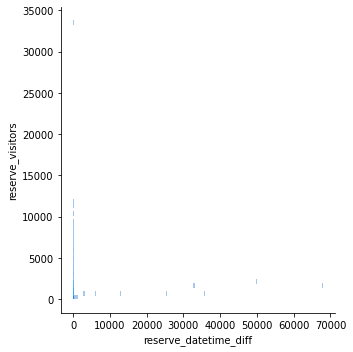

In [42]:
copy_ar_2 = copy_ar.groupby(
        ['reserve_datetime_diff'], as_index=False)[[
            'reserve_visitors'
        ]].sum()
sns.displot(copy_ar_2, x = copy_ar_2["reserve_datetime_diff"], y = copy_ar_2["reserve_visitors"], kind="hist")

In [ ]:
data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])

In [ ]:
display(data['tes'])

,id,visitors,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27
...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,2017-05-27
32015,air_fff68b929994bfbd_2017-05-28,0,2017-05-28
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30


In [ ]:
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])

In [ ]:
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))

In [ ]:
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [ ]:
data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


In [ ]:
data['tes']['air_store_id'].unique()

array(['air_00a91d42b08b08d9', 'air_0164b9927d20bcc3',
       'air_0241aa3964b7f861', 'air_0328696196e46f18',
       'air_034a3d5b40d5b1b1', 'air_036d4f1ee7285390',
       'air_0382c794b73b51ad', 'air_03963426c9312048',
       'air_04341b588bde96cd', 'air_049f6d5b402a31b2',
       'air_04cae7c1bc9b2a0b', 'air_0585011fa179bcce',
       'air_05c325d315cc17f5', 'air_0647f17b4dc041c8',
       'air_064e203265ee5753', 'air_066f0221b8a4d533',
       'air_06f95ac5c33aca10', 'air_0728814bd98f7367',
       'air_0768ab3910f7967f', 'air_07b314d83059c4d2',
       'air_07bb665f9cdfbdfb', 'air_082908692355165e',
       'air_083ddc520ea47e1e', 'air_0845d8395f30c6bb',
       'air_084d98859256acf0', 'air_0867f7bebad6a649',
       'air_08ba8cd01b3ba010', 'air_08cb3c4ee6cd6a22',
       'air_08ef81d5b7a0d13f', 'air_08f994758a1e76d4',
       'air_09040f6df960ddb8', 'air_0919d54f0c9a24b8',
       'air_09661c0f3259cc04', 'air_09a845d5b5944b01',
       'air_09fd1f5c58583141', 'air_0a74a5408a0b8642',
       'ai

In [ ]:
unique_stores = data['tes']['air_store_id'].unique()

In [ ]:
len(unique_stores)

821

In [ ]:
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

In [ ]:
stores.head()

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0


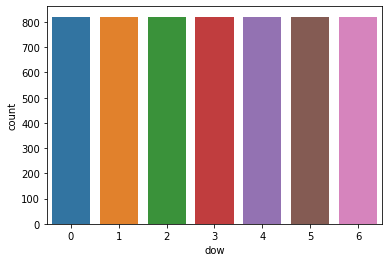

In [ ]:
import seaborn as sns
sns.countplot(x='dow', data=stores)

In [ ]:
stores['dow'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0
1       0
2       0
3       0
4       0
       ..
5742    6
5743    6
5744    6
5745    6
5746    6
Name: dow, Length: 5747, dtype: int64>

In [ ]:
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })

In [ ]:
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0


In [ ]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])

In [ ]:
lbl = preprocessing.LabelEncoder() # 왜 label encoder를 해야하나? 수치형 데이터처럼 인식이 되는거라서
# 수치 관계가 없는데 label encoder를 쓰면 문제가 될 수도 있음.
# one hot encoding하면 열이 많아짐

In [ ]:
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])

In [ ]:
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [ ]:
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,7,82,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,2,102,34.692337,135.472229


In [ ]:
data['hol']['visit_date'] =pd.to_datetime(data['hol']['visit_date'])

In [ ]:
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])

In [ ]:
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0


In [ ]:
pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']).columns

Index(['air_store_id', 'visit_date', 'visitors', 'dow', 'year', 'month',
       'day_of_week', 'holiday_flg'],
      dtype='object')

In [ ]:
data['tra'].columns

Index(['air_store_id', 'visit_date', 'visitors', 'dow', 'year', 'month'], dtype='object')

In [ ]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

In [ ]:
train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

In [ ]:
train.columns

Index(['air_store_id', 'visit_date', 'visitors', 'dow', 'year', 'month',
       'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors',
       'count_observations', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude'],
      dtype='object')

In [ ]:
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

In [ ]:
col = [
    c for c in train
    if c not in ['id', 'air_store_id', 'visit_date', 'visitors']
]

In [ ]:
print(col)

['dow', 'year', 'month', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'reserve_datetime_diff_x', 'reserve_visitors_x', 'reserve_datetime_diff_y', 'reserve_visitors_y']


In [ ]:
train.isnull().sum()

air_store_id               0
visit_date                 0
visitors                   0
dow                        0
year                       0
month                      0
min_visitors               0
mean_visitors              0
median_visitors            0
max_visitors               0
count_observations         0
air_genre_name             0
air_area_name              0
latitude                   0
longitude                  0
reserve_datetime_diff_x    0
reserve_visitors_x         0
reserve_datetime_diff_y    0
reserve_visitors_y         0
dtype: int64

In [ ]:
# 결측값 ??
train = train.fillna(-1)
test = test.fillna(-1)

In [ ]:
print('Binding to float32')


Binding to float32


In [ ]:
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

In [ ]:
print(train.shape, test.shape)
display(train.head())
display(test.head())

(252108, 19) (32019, 20)


,air_store_id,visit_date,visitors,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,2.0,20.292307,21.0,54.0,65.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,4.0,34.738461,35.0,61.0,65.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,6.0,27.651516,27.0,53.0,66.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0


,id,visitors,visit_date,air_store_id,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,2.0,2.000000,2.0,2.0,1.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1.0,22.457144,19.0,47.0,35.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,1.0,24.350000,24.5,43.0,40.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,15.0,28.125000,28.0,52.0,40.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,15.0,29.868422,30.0,47.0,38.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0


In [ ]:
train_ids = list(train['air_store_id'])
test_ids = list(test['air_store_id'])
common_ids = sorted(list(set(train_ids).intersection(test_ids)))
print(len(train_ids), len(test_ids), len(common_ids))

252108 32019 821


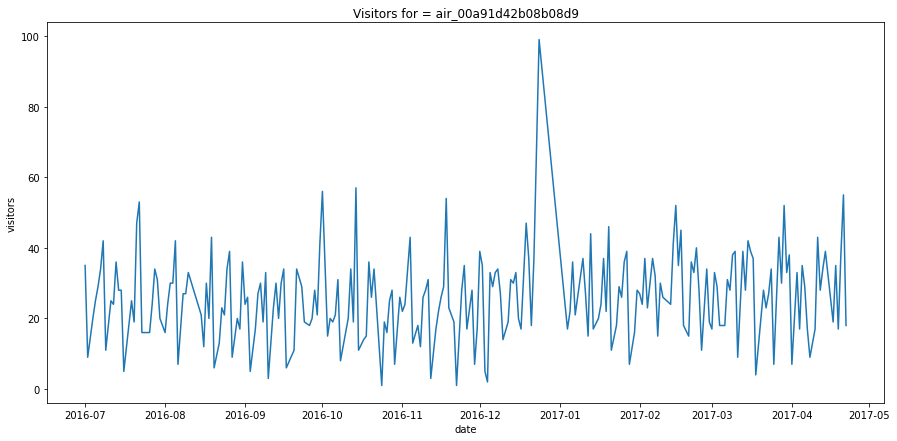

In [ ]:
store_id = common_ids[0]
plt.figure(figsize=(15,7))
plt.plot(train.loc[train['air_store_id'] == store_id, 'visit_date'], train.loc[train['air_store_id'] == store_id, 'visitors'])
plt.title("Visitors for = {}".format(store_id))
plt.xlabel("date")
plt.ylabel("visitors")
plt.show()

In [ ]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values)
test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)
print(train_x.shape, train_y.shape, test_x.shape)

(252108, 16) (252108,) (32019, 16)


In [ ]:
%%time
# fitting the model
gbm0 = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=60,
    learning_rate=0.01,
    n_estimators=10000)

gbm0.fit(train_x, train_y, eval_metric='rmse', verbose=100)

CPU times: user 5min 15s, sys: 2.84 s, total: 5min 18s
Wall time: 2min 42s


In [ ]:
predict_y = gbm0.predict(test_x)
test['visitors'] = np.expm1(predict_y)
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_00a91d42b08b08d9_2017-04-23,1.949772,2017-04-23,air_00a91d42b08b08d9,6,2017,4,2.0,2.000000,2.0,2.0,1.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
1,air_00a91d42b08b08d9_2017-04-24,18.949070,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1.0,22.457144,19.0,47.0,35.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
2,air_00a91d42b08b08d9_2017-04-25,23.865264,2017-04-25,air_00a91d42b08b08d9,1,2017,4,1.0,24.350000,24.5,43.0,40.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
3,air_00a91d42b08b08d9_2017-04-26,27.781386,2017-04-26,air_00a91d42b08b08d9,2,2017,4,15.0,28.125000,28.0,52.0,40.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
4,air_00a91d42b08b08d9_2017-04-27,29.641800,2017-04-27,air_00a91d42b08b08d9,3,2017,4,15.0,29.868422,30.0,47.0,38.0,6,44,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0


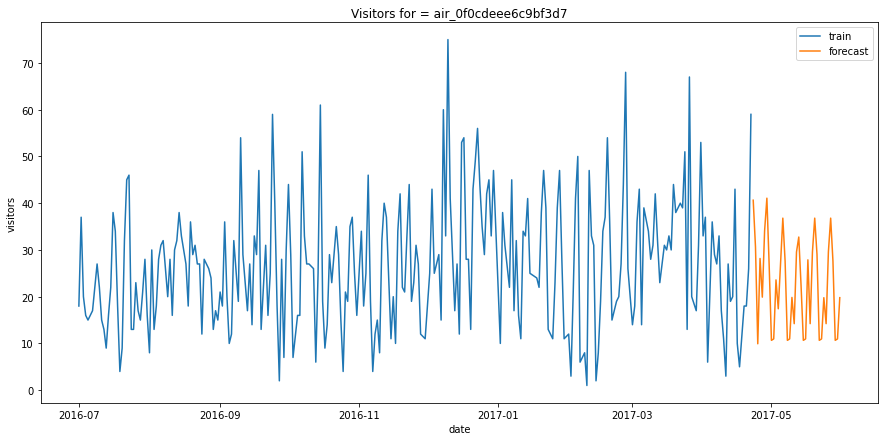

For store = air_0f0cdeee6c9bf3d7


,visit_date,visitors
36696,2017-04-12,27
36697,2017-04-13,19
36698,2017-04-14,20
36699,2017-04-15,43
36700,2017-04-16,10
36701,2017-04-17,5
36702,2017-04-19,18
36703,2017-04-20,18
36704,2017-04-21,26
36705,2017-04-22,59


Forecast for future dates


,visit_date,visitors
1599,2017-04-23,40.637753
1600,2017-04-24,30.631283
1601,2017-04-25,9.924194
1602,2017-04-26,28.176028
1603,2017-04-27,19.902324
1604,2017-04-28,34.082850
1605,2017-04-29,41.073400
1606,2017-04-30,26.795974
1607,2017-05-01,10.659379
1608,2017-05-02,10.968624


In [ ]:
store_id = common_ids[41]
plt.figure(figsize=(15,7))
plt.plot(train.loc[train['air_store_id'] == store_id, 'visit_date'], train.loc[train['air_store_id'] == store_id, 'visitors'], label='train')
plt.plot(test.loc[test['air_store_id'] == store_id, 'visit_date'], test.loc[test['air_store_id'] == store_id, 'visitors'], label='forecast')
plt.title("Visitors for = {}".format(store_id))
plt.xlabel("date")
plt.ylabel("visitors")
plt.legend()
plt.show()

print("For store = {}".format(store_id))
display(train.loc[train['air_store_id'] == store_id, ['visit_date', 'visitors']].tail(10))
print("Forecast for future dates")
display(test.loc[test['air_store_id'] == store_id, ['visit_date', 'visitors']].head(10))